In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN.git
# ! git pull origin master
! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), 22.41 KiB | 2.24 MiB/s, done.
From https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
# VOC 2012 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [5]:
# VOC 2007 Dataset Download and extract

# ! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# ! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
# !tar -xvf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/dataset"
# !tar -xvf "/content/VOCtest_06-Nov-2007.tar" -C "/content/dataset"
# clear_output()

In [6]:
! python src/xml2json.py ./dataset/VOCdevkit 2012

5717
5823
11540


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

IMG_PATH        = "./dataset/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path   = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"


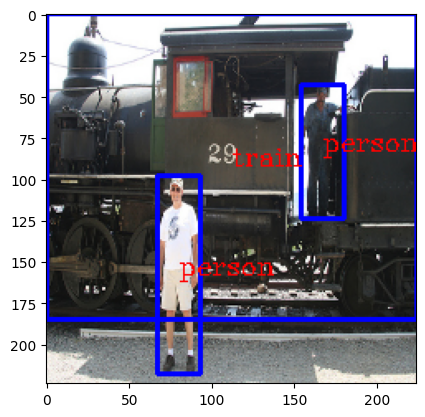

In [8]:

target_size = 224

seed = 42
device = "cuda"

data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

example = data_list[0]
example

img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [9]:
anchor_grid    = [7, 4, 2, 1] # Number of grid-elements per dimension
anchor_zooms   = [0.7, 1.0, 1.3] # How much bigger/smaller each default box will be (percentage)
anchor_ratios  = [(1.0, 1.0), (1.0, 0.5), (0.5, 1.0)] # Ratio between (width, height)

anchor_scales  = [(anc*h, anc*w) for anc in anchor_zooms for (h,w) in anchor_ratios]
anchor_offsets = [1/(2*o) for o in anchor_grid]
num_boxes      = len(anchor_scales)

anchor_x = [np.repeat(np.linspace(ao, 1-ao, ag), ag) for (ao, ag) in zip(anchor_offsets, anchor_grid)]
anchor_x = np.concatenate(anchor_x)

anchor_y = [np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anchor_offsets, anchor_grid)]
anchor_y = np.concatenate(anchor_y)

anchor_centers = np.repeat(np.stack([anchor_x, anchor_y], axis=1), num_boxes, axis=0)

anchor_sizes  = [np.array([[w/ag, h/ag] for _ in range(ag**2) for w, h in anchor_scales])
                 for ag in anchor_grid]
anchor_sizes = np.concatenate(anchor_sizes)

anchors = np.concatenate([anchor_centers, anchor_sizes], axis=1)
anchors = torch.from_numpy(anchors).float()
anchors = anchors.to(device)

class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std  = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std

        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

val_dataset   = PascalData(data_list[split_idx:])
val_loader     = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

class StandardConv(nn.Module):
    def __init__(self, in_channels, out_channels, p, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=p)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        return x

class OutputConv(nn.Module):
    def __init__(self, in_channels, num_boxes):
        super().__init__()
        self.num_boxes = num_boxes
        self.conv_1 = nn.Conv2d(in_channels, (len(id_cat) + 1) * self.num_boxes, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels, 4 * self.num_boxes, kernel_size=3, padding=1)

    def flatten_conv(self, x):
        samples, channels, _, _ = x.size()
        x = x.permute(0, 2, 3, 1).contiguous()
        return x.view(samples, -1, int(channels / self.num_boxes))

    def forward(self, x):
        # [class predictions, box coordinates]
        return [self.flatten_conv(self.conv_1(x)),
                self.flatten_conv(self.conv_2(x))]

class Model(nn.Module):
    def __init__(self, num_boxes, p):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.backbone_dropout = nn.Dropout2d(p=p[0])

        self.std_conv = nn.ModuleList([
            StandardConv(512, 256, p[1], stride=1),
            StandardConv(256, 256, p[1], stride=1),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1]),
            StandardConv(256, 256, p[1])
        ])

        self.out_conv = nn.ModuleList([
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes),
            OutputConv(256, num_boxes)
        ])

    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone_dropout(x)

        x = self.std_conv[0](x)
        x = self.std_conv[1](x)
        output_class_0, output_bb_0 = self.out_conv[0](x)

        x = self.std_conv[2](x)
        output_class_1, output_bb_1 = self.out_conv[1](x)

        x = self.std_conv[3](x)
        output_class_2, output_bb_2 = self.out_conv[2](x)

        x = self.std_conv[4](x)
        output_class_3, output_bb_3 = self.out_conv[3](x)

        # Class, bounding box
        return [torch.cat([output_class_0, output_class_1, output_class_2, output_class_3], dim=1),
                torch.cat([output_bb_0, output_bb_1, output_bb_2, output_bb_3], dim=1)
                ]

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

def find_overlap(bb_true_i, anchors, jaccard_overlap):
    jaccard_tensor = jaccard(anchors, bb_true_i)
    _, max_overlap = torch.max(jaccard_tensor, dim=0)

    overlap_list = []
    for i in range(len(bb_true_i)):
        threshold_overlap = (jaccard_tensor[:, i] > jaccard_overlap).nonzero()

        if len(threshold_overlap) > 0:
            threshold_overlap = threshold_overlap[:, 0]
            overlap = torch.cat([max_overlap[i].view(1), threshold_overlap])
            overlap = torch.unique(overlap)
        else:
            overlap = max_overlap[i].view(1)
        overlap_list.append(overlap)
    return overlap_list

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()

class SSDLoss(nn.Module):
    def __init__(self, loc_factor, anchors, jaccard_overlap, **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        self.anchors = anchors

    @staticmethod
    def one_hot_encoding(labels, num_classes):
        # print(labels)
        # print(num_classes)
        labels_cpu = torch.tensor(labels, device = 'cpu')
        # print(labels_cpu)
        one_hot_results = torch.eye(num_classes)[labels_cpu]
        # print(one_hot_results)
        return one_hot_results


    @staticmethod
    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true):
        loc_loss = 0.0
        class_loss = 0.0

        for i in range(len(class_true)):  # Batch level
            class_hat_i = class_hat[i, :, :]
            bb_true_i = bb_true[i]
            class_true_i = class_true[i]
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(device)

            overlap_list = find_overlap(bb_true_i.squeeze(0), self.anchors, self.jaccard_overlap)

            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j]

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), self.anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

loc_factor = 10.0
jaccard_overlap = 0.6

loss = SSDLoss(loc_factor=loc_factor, anchors=anchors, jaccard_overlap=jaccard_overlap)

p = [0.2, 0.5]

torch.manual_seed(seed)
model = Model(num_boxes=num_boxes, p=p).to(device)
model.change_freezing(False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s]


In [10]:
n_epochs = 100
lr = 1e-3
wd = 1e-2

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

jaccard_threshold = 0.5
map_eval = MAP(model, val_dataset, jaccard_threshold, anchors)

torch.manual_seed(seed)
random.seed(seed)

from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(n_epochs):
    model.train()

    train_loss, train_loc_loss, train_class_loss  = 0.0, 0.0, 0.0
    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:
        for _, (x, bb_true, class_true) in enumerate(train_loader):
            model.zero_grad()
            class_hat, bb_hat = model(x)

            batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)

            batch_loss.backward()
            optimizer.step()

            train_loss       += batch_loss.detach().to("cpu").numpy()
            train_class_loss += batch_class.detach().to("cpu").numpy()
            train_loc_loss   += batch_loc.detach().to("cpu").numpy()

            pbar.update(1)

        train_loss       =  np.round(train_loss / len(train_loader), 6)
        train_loc_loss   =  np.round(train_loc_loss / len(train_loader), 6)
        train_class_loss =  np.round(train_class_loss / len(train_loader), 6)

    val_loss, val_loc_loss, val_class_loss = 0.0, 0.0, 0.0
    with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:
        for _, (x, bb_true, class_true) in enumerate(val_loader):
            class_hat, bb_hat = model(x)

            batch_loss, batch_loc, batch_class = loss(class_hat, bb_hat, class_true, bb_true)
            val_loss       += batch_loss.detach().to("cpu").numpy()
            val_loc_loss   += batch_loc.detach().to("cpu").numpy()
            val_class_loss += batch_class.detach().to("cpu").numpy()

            pbar.update(1)

        val_loss       = np.round(val_loss / len(val_loader), 6)
        val_loc_loss   = np.round(val_loc_loss / len(val_loader), 6)
        val_class_loss = np.round(val_class_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if (epoch+1) % 5 == 0:
        print(f"----- Epoch {epoch+1} -----")
        print(f"Train loss       : {train_loss}")
        print(f"Train loc loss   : {train_loc_loss}")
        print(f"Train class loss : {train_class_loss}")
        print(f"Val loss         : {val_loss}")
        print(f"Val loc loss     : {val_loc_loss}")
        print(f"Val class loss   : {val_class_loss}")
        print(f"Val mAP          : {mAP}")

<ipython-input-10-459510381c3a>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:


Train 1:   0%|          | 0/82 [00:00<?, ?it/s]

<ipython-input-9-76f96ab4cf75>:223: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_cpu = torch.tensor(labels, device = 'cpu')
<ipython-input-10-459510381c3a>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:


Valid 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train 2:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train 3:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 3:   0%|          | 0/10 [00:00<?, ?it/s]

Train 4:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 4:   0%|          | 0/10 [00:00<?, ?it/s]

Train 5:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 5:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 5 -----
Train loss       : 6.461025
Train loc loss   : 0.199995
Train class loss : 4.46108
Val loss         : 6.88072
Val loc loss     : 0.211855
Val class loss   : 4.762172
Val mAP          : 0.166048


Train 6:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 6:   0%|          | 0/10 [00:00<?, ?it/s]

Train 7:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 7:   0%|          | 0/10 [00:00<?, ?it/s]

Train 8:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 8:   0%|          | 0/10 [00:00<?, ?it/s]

Train 9:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train 10:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 10:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 10 -----
Train loss       : 5.868954
Train loc loss   : 0.181232
Train class loss : 4.056634
Val loss         : 6.519823
Val loc loss     : 0.231424
Val class loss   : 4.205582
Val mAP          : 0.230659


Train 11:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 11:   0%|          | 0/10 [00:00<?, ?it/s]

Train 12:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 12:   0%|          | 0/10 [00:00<?, ?it/s]

Train 13:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 13:   0%|          | 0/10 [00:00<?, ?it/s]

Train 14:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 14:   0%|          | 0/10 [00:00<?, ?it/s]

Train 15:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 15:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 15 -----
Train loss       : 5.544935
Train loc loss   : 0.172149
Train class loss : 3.823444
Val loss         : 5.786133
Val loc loss     : 0.193987
Val class loss   : 3.846266
Val mAP          : 0.282766


Train 16:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 16:   0%|          | 0/10 [00:00<?, ?it/s]

Train 17:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 17:   0%|          | 0/10 [00:00<?, ?it/s]

Train 18:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 18:   0%|          | 0/10 [00:00<?, ?it/s]

Train 19:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 19:   0%|          | 0/10 [00:00<?, ?it/s]

Train 20:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 20:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 20 -----
Train loss       : 5.271125
Train loc loss   : 0.162185
Train class loss : 3.649278
Val loss         : 5.665496
Val loc loss     : 0.170147
Val class loss   : 3.964029
Val mAP          : 0.325324


Train 21:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 21:   0%|          | 0/10 [00:00<?, ?it/s]

Train 22:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 22:   0%|          | 0/10 [00:00<?, ?it/s]

Train 23:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 23:   0%|          | 0/10 [00:00<?, ?it/s]

Train 24:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 24:   0%|          | 0/10 [00:00<?, ?it/s]

Train 25:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 25:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 25 -----
Train loss       : 5.048183
Train loc loss   : 0.154274
Train class loss : 3.505443
Val loss         : 5.584399
Val loc loss     : 0.193668
Val class loss   : 3.647719
Val mAP          : 0.364709


Train 26:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 26:   0%|          | 0/10 [00:00<?, ?it/s]

Train 27:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 27:   0%|          | 0/10 [00:00<?, ?it/s]

Train 28:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 28:   0%|          | 0/10 [00:00<?, ?it/s]

Train 29:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 29:   0%|          | 0/10 [00:00<?, ?it/s]

Train 30:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 30:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 30 -----
Train loss       : 4.865768
Train loc loss   : 0.146676
Train class loss : 3.399013
Val loss         : 5.560336
Val loc loss     : 0.198699
Val class loss   : 3.57335
Val mAP          : 0.391811


Train 31:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 31:   0%|          | 0/10 [00:00<?, ?it/s]

Train 32:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 32:   0%|          | 0/10 [00:00<?, ?it/s]

Train 33:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 33:   0%|          | 0/10 [00:00<?, ?it/s]

Train 34:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 34:   0%|          | 0/10 [00:00<?, ?it/s]

Train 35:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 35:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 35 -----
Train loss       : 4.716295
Train loc loss   : 0.14197
Train class loss : 3.296597
Val loss         : 5.807254
Val loc loss     : 0.213384
Val class loss   : 3.673413
Val mAP          : 0.412659


Train 36:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 36:   0%|          | 0/10 [00:00<?, ?it/s]

Train 37:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 37:   0%|          | 0/10 [00:00<?, ?it/s]

Train 38:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 38:   0%|          | 0/10 [00:00<?, ?it/s]

Train 39:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 39:   0%|          | 0/10 [00:00<?, ?it/s]

Train 40:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 40:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 40 -----
Train loss       : 4.574316
Train loc loss   : 0.135112
Train class loss : 3.223194
Val loss         : 5.25246
Val loc loss     : 0.164097
Val class loss   : 3.611489
Val mAP          : 0.410801


Train 41:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 41:   0%|          | 0/10 [00:00<?, ?it/s]

Train 42:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 42:   0%|          | 0/10 [00:00<?, ?it/s]

Train 43:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 43:   0%|          | 0/10 [00:00<?, ?it/s]

Train 44:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 44:   0%|          | 0/10 [00:00<?, ?it/s]

Train 45:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 45:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 45 -----
Train loss       : 4.485441
Train loc loss   : 0.13319
Train class loss : 3.153539
Val loss         : 5.573333
Val loc loss     : 0.190752
Val class loss   : 3.665814
Val mAP          : 0.440129


Train 46:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 46:   0%|          | 0/10 [00:00<?, ?it/s]

Train 47:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 47:   0%|          | 0/10 [00:00<?, ?it/s]

Train 48:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 48:   0%|          | 0/10 [00:00<?, ?it/s]

Train 49:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 49:   0%|          | 0/10 [00:00<?, ?it/s]

Train 50:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 50:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 50 -----
Train loss       : 4.369927
Train loc loss   : 0.127018
Train class loss : 3.099744
Val loss         : 5.224403
Val loc loss     : 0.153582
Val class loss   : 3.688586
Val mAP          : 0.437707


Train 51:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 51:   0%|          | 0/10 [00:00<?, ?it/s]

Train 52:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 52:   0%|          | 0/10 [00:00<?, ?it/s]

Train 53:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 53:   0%|          | 0/10 [00:00<?, ?it/s]

Train 54:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 54:   0%|          | 0/10 [00:00<?, ?it/s]

Train 55:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 55:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 55 -----
Train loss       : 4.286818
Train loc loss   : 0.125056
Train class loss : 3.036255
Val loss         : 4.947335
Val loc loss     : 0.153182
Val class loss   : 3.415513
Val mAP          : 0.450933


Train 56:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 56:   0%|          | 0/10 [00:00<?, ?it/s]

Train 57:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 57:   0%|          | 0/10 [00:00<?, ?it/s]

Train 58:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 58:   0%|          | 0/10 [00:00<?, ?it/s]

Train 59:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 59:   0%|          | 0/10 [00:00<?, ?it/s]

Train 60:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 60:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 60 -----
Train loss       : 4.195031
Train loc loss   : 0.118685
Train class loss : 3.008186
Val loss         : 5.238822
Val loc loss     : 0.149509
Val class loss   : 3.743733
Val mAP          : 0.463326


Train 61:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 61:   0%|          | 0/10 [00:00<?, ?it/s]

Train 62:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 62:   0%|          | 0/10 [00:00<?, ?it/s]

Train 63:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 63:   0%|          | 0/10 [00:00<?, ?it/s]

Train 64:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 64:   0%|          | 0/10 [00:00<?, ?it/s]

Train 65:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 65:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 65 -----
Train loss       : 4.117377
Train loc loss   : 0.117183
Train class loss : 2.945547
Val loss         : 4.606335
Val loc loss     : 0.139582
Val class loss   : 3.210519
Val mAP          : 0.46089


Train 66:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 66:   0%|          | 0/10 [00:00<?, ?it/s]

Train 67:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 67:   0%|          | 0/10 [00:00<?, ?it/s]

Train 68:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 68:   0%|          | 0/10 [00:00<?, ?it/s]

Train 69:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 69:   0%|          | 0/10 [00:00<?, ?it/s]

Train 70:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 70:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 70 -----
Train loss       : 4.100277
Train loc loss   : 0.118036
Train class loss : 2.919921
Val loss         : 4.842329
Val loc loss     : 0.157284
Val class loss   : 3.26949
Val mAP          : 0.462901


Train 71:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 71:   0%|          | 0/10 [00:00<?, ?it/s]

Train 72:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 72:   0%|          | 0/10 [00:00<?, ?it/s]

Train 73:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 73:   0%|          | 0/10 [00:00<?, ?it/s]

Train 74:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 74:   0%|          | 0/10 [00:00<?, ?it/s]

Train 75:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 75:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 75 -----
Train loss       : 3.974835
Train loc loss   : 0.111011
Train class loss : 2.864721
Val loss         : 5.896567
Val loc loss     : 0.147068
Val class loss   : 4.425888
Val mAP          : 0.467994


Train 76:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 76:   0%|          | 0/10 [00:00<?, ?it/s]

Train 77:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 77:   0%|          | 0/10 [00:00<?, ?it/s]

Train 78:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 78:   0%|          | 0/10 [00:00<?, ?it/s]

Train 79:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 79:   0%|          | 0/10 [00:00<?, ?it/s]

Train 80:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 80:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 80 -----
Train loss       : 3.934216
Train loc loss   : 0.109993
Train class loss : 2.834283
Val loss         : 5.104993
Val loc loss     : 0.165604
Val class loss   : 3.448955
Val mAP          : 0.487524


Train 81:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 81:   0%|          | 0/10 [00:00<?, ?it/s]

Train 82:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 82:   0%|          | 0/10 [00:00<?, ?it/s]

Train 83:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 83:   0%|          | 0/10 [00:00<?, ?it/s]

Train 84:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 84:   0%|          | 0/10 [00:00<?, ?it/s]

Train 85:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 85:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 85 -----
Train loss       : 3.832674
Train loc loss   : 0.105687
Train class loss : 2.775806
Val loss         : 4.841694
Val loc loss     : 0.150276
Val class loss   : 3.338931
Val mAP          : 0.489955


Train 86:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 86:   0%|          | 0/10 [00:00<?, ?it/s]

Train 87:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 87:   0%|          | 0/10 [00:00<?, ?it/s]

Train 88:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 88:   0%|          | 0/10 [00:00<?, ?it/s]

Train 89:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 89:   0%|          | 0/10 [00:00<?, ?it/s]

Train 90:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 90:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 90 -----
Train loss       : 3.794741
Train loc loss   : 0.104427
Train class loss : 2.750475
Val loss         : 5.132319
Val loc loss     : 0.169516
Val class loss   : 3.437154
Val mAP          : 0.475271


Train 91:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 91:   0%|          | 0/10 [00:00<?, ?it/s]

Train 92:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 92:   0%|          | 0/10 [00:00<?, ?it/s]

Train 93:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 93:   0%|          | 0/10 [00:00<?, ?it/s]

Train 94:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 94:   0%|          | 0/10 [00:00<?, ?it/s]

Train 95:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 95:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 95 -----
Train loss       : 3.73882
Train loc loss   : 0.101723
Train class loss : 2.721589
Val loss         : 5.035908
Val loc loss     : 0.155906
Val class loss   : 3.47685
Val mAP          : 0.493597


Train 96:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 96:   0%|          | 0/10 [00:00<?, ?it/s]

Train 97:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 97:   0%|          | 0/10 [00:00<?, ?it/s]

Train 98:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 98:   0%|          | 0/10 [00:00<?, ?it/s]

Train 99:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 99:   0%|          | 0/10 [00:00<?, ?it/s]

Train 100:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 100:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 100 -----
Train loss       : 3.667166
Train loc loss   : 0.09953
Train class loss : 2.671865
Val loss         : 5.108578
Val loc loss     : 0.163446
Val class loss   : 3.474116
Val mAP          : 0.49908


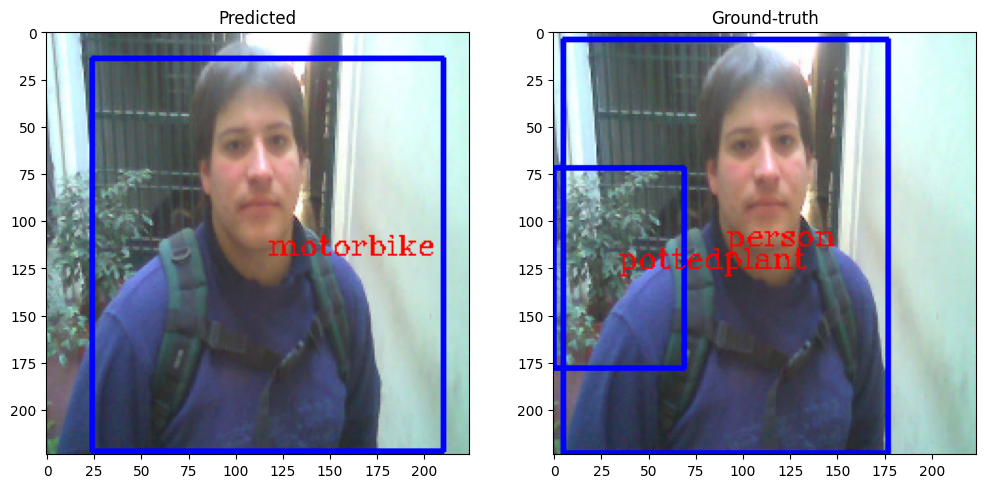

In [11]:

background_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
img_file = val_dataset.data_list[i].filename

model.eval()
class_hat, bb_hat = model(x.unsqueeze(0))

bb_hat = dt.invert_transformation(bb_hat.squeeze(0), anchors)
bb_hat = bb_hat * target_size

class_hat = class_hat.sigmoid().squeeze(0)

# Filtering with < since we want low probability of background
bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]
bb_hat = bb_hat.detach().cpu().numpy()
class_hat = class_hat[class_hat[:,0] < background_threshold, :]
class_preds = class_hat[:, 1:]

if len(class_preds) > 0:
    prob, class_id = class_preds.max(1)
    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()
else:
    prob = []

output_bb = [PredBoundingBox(probability=prob[j],
                             class_id=class_id[j],
                             classname=id_cat[class_id[j]],
                             bounding_box=[bb_hat[j, 0],
                                           bb_hat[j, 1],
                                           bb_hat[j, 2],
                                           bb_hat[j, 3]])
             for j in range(len(prob))]

output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=True)

filtered_bb = non_max_suppression(output_bb)

example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in filtered_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()